c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


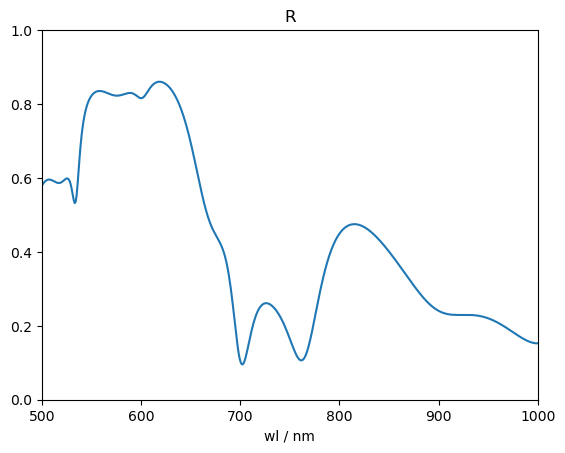

In [3]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
from utils.loss import calculate_RMS
import matplotlib.pyplot as plt

# Initialize: config for TML
WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.


def plot_film(f: FilmSimple):
    f.add_spec_param(INC_ANG, WLS)
    spec_target = f.get_spec()
    spec_target.calculate() # compile cuda kernel func
    plot_spectrum(spec_target)

np.random.seed(1)
f_target = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(30) * 100) # target film for TML
plot_film(f_target)

In [4]:
# Load trained films data and construct Design objects

designs = []

for run_idx in range(200):
    try:
        design = DesignSimple(f_target,
                            FilmSimple('SiO2', 
                                        'TiO2',
                                        'SiO2',
                                        np.loadtxt(f'./../raw_design_result/50iters_0to2OT_200run/run_{run_idx}/final')*1000.
                                        ),
                            init_ot=run_idx / 200 * f_target.get_optical_thickness() # init ot is ratio * target ot
                            )
        design.film.add_spec_param(inc_ang=INC_ANG, wls=WLS)
        design.film.calculate_spectrum()
        design.calculate_loss()

        designs.append(design)
    except Exception as e:
        print(e, f"(run {run_idx})")
        continue # skip invalid d
        

Should be 1 dim array! (run 0)


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


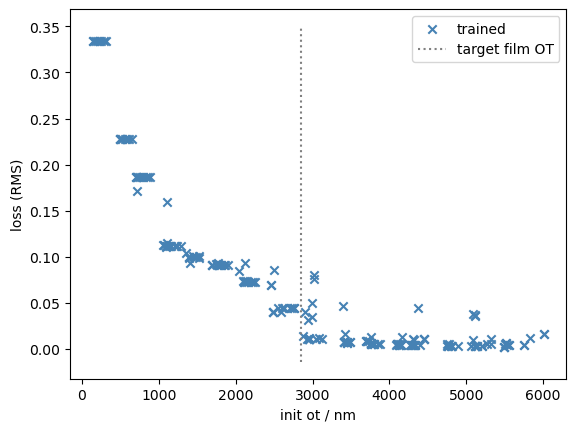

In [13]:
def plot(design_list):
    wl = 750.
    fig, ax = plt.subplots(1, 1)
    for design in design_list:
        ax.scatter(design.film.get_optical_thickness(wl), design.loss, c='steelblue', marker='x')
    # scatter the first dot for the legend
    design = designs[0]
    ax.scatter(design.film.get_optical_thickness(wl), design.loss, c='steelblue', marker='x', label='trained')

    target_ot = design.target_film.get_optical_thickness(wl)
    ax.plot([target_ot, target_ot], ax.get_ylim(), label='target film OT', c='gray', ls=':')
    
    
    ax.legend()
    ax.set_xlabel('init ot / nm')
    ax.set_ylabel('loss (RMS)')
    ax.set_ylim(0, None) # set lower bound of y to zero


plot(designs)